<AxesSubplot:xlabel='year'>

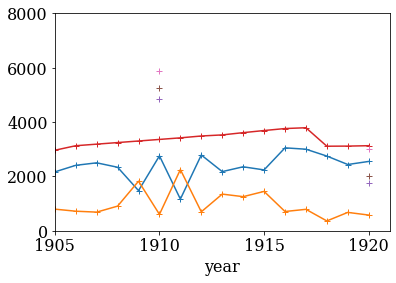

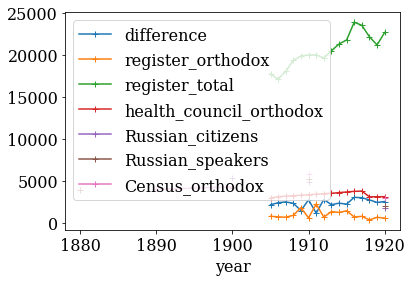

In [71]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

data_dir = Path('../data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['total'] = poll_tax.total_women + poll_tax.total_men
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1905, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([difference, poll_tax.orthodox, poll_tax.total, health_council, foreigners, language, religion]).T
data.columns = ['difference', 'register_orthodox', 'register_total', 'health_council_orthodox', 'Russian_citizens', 'Russian_speakers', 'Census_orthodox']
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=False, xlim=(1905, 1921), ylim=(0, 8000))
data.plot(marker='+')

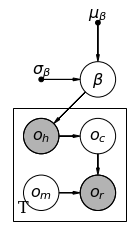

In [72]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('sigma', r'$\sigma_{\beta}$', 1, 3, fixed=True)
pgm.add_node('mu', r'$\mu_{\beta}$', 2, 4, fixed=True)
pgm.add_node('health_orthodox', r'$o_h$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('city_orthodox', r'$o_c$', 2, 2, fixed=False, scale=scale, observed=False)
pgm.add_node('register_orthodox', r'$o_r$', 2, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('missing_orthodox', r'$o_m$', 1, 1, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_city', r'$\beta$', 2, 3, fixed=False, scale=scale, observed=False)

pgm.add_edge('sigma', 'beta_orthodox_city', directed=True)
pgm.add_edge('mu', 'beta_orthodox_city', directed=True)
pgm.add_edge('beta_orthodox_city', 'health_orthodox', directed=True)
pgm.add_edge('city_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('health_orthodox', 'city_orthodox', directed=True)
pgm.add_edge('missing_orthodox', 'register_orthodox', directed=True)

pgm.add_plate([0.5, 0.5, 2, 2], 'T')

pgm.render()

Model:

$ o_r = o_c - o_m $

In [78]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

years = pd.Series(poll_tax.index - 1905)

with pm.Model() as model:
    mu = np.array([3500., 0.1])
    sigma = np.array([1., 0.01])
    t = pm.Data('t', years)
    n = len(poll_tax.index)
    beta = pm.Normal('beta', mu=mu, sigma=sigma, shape=2)
    mu_oh = beta[0] + beta[1] * t
    o_h = pm.Normal('o_h', mu_oh, observed=health_council)
    o_m = pm.Normal('o_m', mu=2000., sigma=1, shape=n)
    mu_or = 0.7 * o_h - o_m
    sigma_or = 0.01
    o_r = pm.Normal('o_r', mu=mu_or, sigma=sigma_or, observed=poll_tax.orthodox)
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag")
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_m, beta]


RuntimeError: Chain 1 failed.